In [5]:
import sys
sys.path.append('..')

In [6]:
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import torch.nn.functional as F
import json
import random
import copy

from dsets import ClinicalDiseaseDataset

In [7]:
model = AutoModelForCausalLM.from_pretrained("microsoft/BioGPT-Large-PubMedQA")
tokenizer = AutoTokenizer.from_pretrained("microsoft/BioGPT-Large-PubMedQA")

In [24]:
with_context = False
dataset = ClinicalDiseaseDataset('../data', with_context=with_context)
replacement_subjects = json.load(open('../data/disease_keywords.json'))

Loaded dataset with 50 samples


In [23]:
dataset[0], replacement_subjects["0"]

({'id': 0,
  'subject': 'strabismus',
  'attribute': 'no',
  'question': 'landolt c and snellen e acuity: differences in strabismus amblyopia?',
  'context': 'assessment of visual acuity depends on the optotypes used for measurement. the ability to recognize different optotypes differs even if their critical details appear under the same visual angle. since optotypes are evaluated on individuals with good visual acuity and without eye disorders, differences in the lower visual acuity range cannot be excluded. in this study, visual acuity measured with the snellen e was compared to the landolt c acuity.100 patients (age 8 - 90 years, median 60.5 years) with various eye disorders, among them 39 with amblyopia due to strabismus, and 13 healthy volunteers were tested. charts with the snellen e and the landolt c (precision vision) which mimic the etdrs charts were used to assess visual acuity. three out of 5 optotypes per line had to be correctly identified, while wrong answers were monitor

In [12]:
def get_answer_prob(prompt, answer):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    # Forward pass to get the logits
    with torch.no_grad():
        outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])

    # Extract logits at the last position (where answer starts)
    logits = outputs.logits[0, -1, :]  # Shape: [vocab_size]

    # Get token IDs for "Yes", "No", and "Maybe"
    yes_token_id = tokenizer(" Yes", add_special_tokens=False)["input_ids"][0]
    no_token_id = tokenizer(" No", add_special_tokens=False)["input_ids"][0]
    maybe_token_id = tokenizer(" Maybe", add_special_tokens=False)["input_ids"][0]

    # Extract logits for the specific tokens
    answer_logits = logits[[yes_token_id, no_token_id, maybe_token_id]]

    # Convert logits to probabilities
    answer_probs = F.softmax(answer_logits, dim=0)

    if answer == 'yes':
        return answer_probs[0].item()
    elif answer == 'no':
        return answer_probs[1].item()
    elif answer == 'maybe':
        return answer_probs[2].item()
    

In [15]:
def make_corrupt_prompt(data):
    clean_prompt = data['prompt']
    subject = data['subject']

    # first choose a random idx then choose a random subject
    idx = random.randint(0, len(replacement_subjects) - 1)
    if idx == data['id']:
        idx = (idx + 1) % len(replacement_subjects)
    new_subject_arr = replacement_subjects[str(idx)]
    new_subject = random.choice(new_subject_arr)

    print('original subject:', subject)
    print('new subject:', new_subject)
    corrupt_prompt = clean_prompt.replace(subject, new_subject)
    return corrupt_prompt

In [25]:
prob_diffs = []
for i in range(len(dataset)):
    data = dataset[i]
    clean_prompt = data['prompt']
    clean_prob = get_answer_prob(clean_prompt, data['attribute'])

    corrupted_prompt = make_corrupt_prompt(data)
    corrupted_prob = get_answer_prob(corrupted_prompt, data['attribute'])

    prob_diffs.append(clean_prob - corrupted_prob)

original subject: strabismus
new subject: self-reported
original subject: colectomy
new subject: family history
original subject: double-balloon enteroscopy
new subject: immunohistochemistry
original subject: sleep disorders
new subject: lymph node involvement
original subject: mutations
new subject: papanicolaou smears
original subject: academic children's hospital
new subject: predict
original subject: family history
new subject: diabetes-educated
original subject: palliative care
new subject: cancer
original subject: cardiovascular
new subject: cervical cancer
original subject: acute respiratory distress syndrome
new subject: double-balloon enteroscopy
original subject: nomograms
new subject: ovarian cancer
original subject: chronic oro-facial pain
new subject: cancer
original subject: immunohistochemistry
new subject: tinnitus
original subject: information system
new subject: rectal cancer
original subject: hepatocellular carcinoma
new subject: logistic
original subject: papanicola

In [17]:
def plot_histogram(data, title):
    plt.hist(data, bins=20)
    plt.title(title)
    plt.xlabel('Answer Token Probability Difference')
    plt.ylabel('Frequency')
    plt.show()

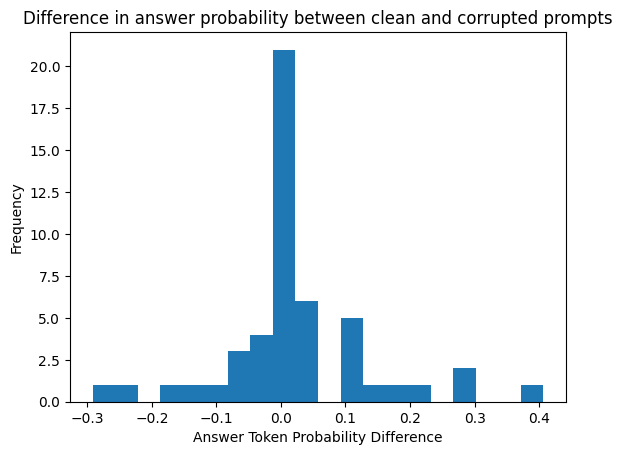

In [26]:
title = 'Difference in answer probability between clean and corrupted prompts'
if with_context:
    title += ' (with context)'
plot_histogram(prob_diffs, title)